# Exam Q1
Michael Neustater - mdn68

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from queue import Queue
import heapq
import itertools

To ensure all functions are declared, run all cells. Make sure text files are included in same dir

In [2]:
"""Read maze from text file"""
def read_maze(file_name):
  text = open(file_name, "r")
  maze = text.readlines()
  for itr, x in enumerate(maze):
    maze[itr] = maze[itr].replace('\n','')
    maze[itr] = list(maze[itr])
    if len(maze[itr]) == 0:
      del maze[itr]

  maze = np.array(maze)
  free_cells = np.count_nonzero(maze == "_")
  probability = 1/free_cells
  prob_maze = np.where(maze == '_',1/free_cells, 0)
  return maze, prob_maze, free_cells

# Question 1

The probability of being in the top left corner is $\frac{1}{total\,number\,of\,free\,cells}$. This is because prior to any movements being made, there is an equal chance of the drone being in any of the unblocked cells. In this case there are 199 free cells so the initial probability for a free cell is $\frac{1}{199}$.

Free Cells: 199
The probability of being in the upper left cell is 0.005025125628140704


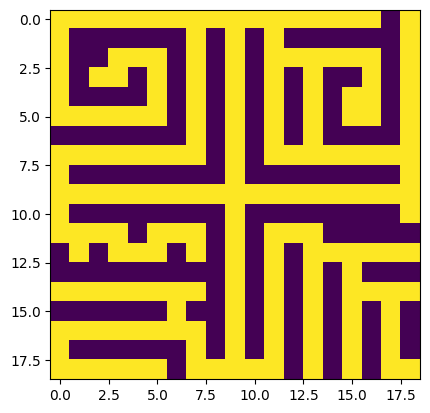

In [3]:
map, prob_map, free_cells = read_maze("Thor23-SA74-VERW-Schematic (Classified).txt")

print(f"Free Cells: {free_cells}")
probability = 1/free_cells
print(f"The probability of being in the upper left cell is {probability}")

plt.imshow(np.where(map == "_", 1, 0)) 

# Question 2
The probability of drone D in a cell N after a movement is:
 $P(D\, in\, N\, after\, move) = P(D\, is\, in\, N\, now)* P(D\, in\, N\, next|\,P\, in\, N\, now\,) +  
P(D\, is\, in\, Right\, now) * P(D\, in\, N\, next|\,P\, in\, Right\, now\,) +  
P(D\, is\, in\, Left\, now) * P(D\, in\, N\, next|\,P\, in\, Left\, now\,)+  
P(D\, is\, in\, Up\, now) * P(D\, in\, N\, next|\,P\, in\, Up\, now\,)+  
P(D\, is\, in\, Down\, now) * P(D\, in\, N\, next|\,P\, in\, Down\, now\,)$


---


Given the movement down, the probability simplifies to:
$P(D\, in\, N\, after\, move) = P(D\, is\, in\, N\, now)* P(D\, in\, N\, next|\,P\, in\, N\, now\,) +  
0 +  
0 +  
P(D\, is\, in\, Up\, now) * P(D\, in\, N\, next|\,P\, in\, Up\, now\,)+  
0$ 

---

This is maximized for cells in which there is a free cell above it and no free cell below:

$P(D\, is\, in\, N\, now)$ and $P(D\, is\, in\, Up\, now)$ = $\frac{1}{199}$

and 

$P(D\, in\, N\, next|\,P\, in\, N\, now\,)$ and $P(D\, in\, N\, next|\,P\, in\, Up\, now\,)$ = 1

Such that the maximum probability cells contain the drone with a probability of $\frac{2}{199}$.

---

This is minimized for cells where there is no free cell above and there is a free cell below:

$P(D\, is\, in\, N\, now)$ and $P(D\, is\, in\, Up\, now)$ = $\frac{1}{199}$

and 

$P(D\, in\, N\, next|\,P\, in\, N\, now\,)$ and $P(D\, in\, N\, next|\,P\, in\, Up\, now\,)$ = 0

So there is a 0 probability for these cells.

(See image below)

Purple denotes walls, 
Blue denotes lowest probability (not including walls), 
Yellow denotes the highest shown probability 
Colors in-between denoting values between min and max

Max Probability = 2/199: True
Min Probabililty = 0 (excluding walls): True


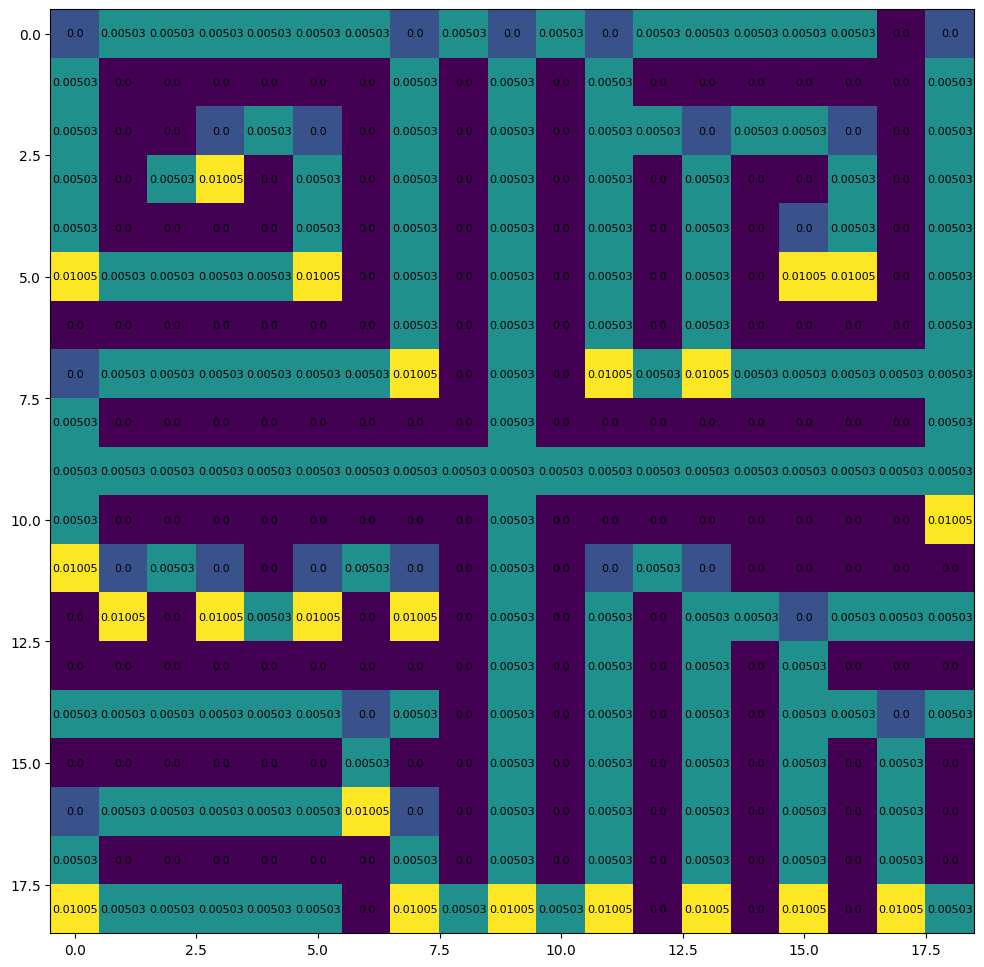

In [4]:

"""Simulate a probability update for a single move down"""
prob_map = np.where(map == '_',1/free_cells, 0)
new_prob_map = np.zeros_like(prob_map)
for i in range(len(prob_map)):
  for j in range(len(prob_map[i])):
    if map[i][j] != 'X':
      if i - 1 >= 0 and map[i - 1][j] != 'X':
        new_prob_map[i][j] = new_prob_map[i][j] + prob_map[i - 1][j]
      if i + 1 >= len(prob_map) or map[i + 1][j] == 'X':
        new_prob_map[i][j] += prob_map[i][j]
    else:
      new_prob_map[i][j] = 0
      
#Used np.where to visually seperate the walls from the 0 probability cells since they both have 0 probability and would display the same
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.imshow(np.where(map != ['X'], np.where(new_prob_map == 0, (new_prob_map) + (1/free_cells/2),new_prob_map) , 0))
"""Displays probabilities in cells Rounded to 5 places"""
for (j,i),label in np.ndenumerate(np.around(new_prob_map, decimals = 5)):
    ax.text(i,j,label,ha='center',va='center', fontsize=8)

#To show output with wall and cells with 0 prob having same color un-comment this line
#plt.imshow(new_prob_map) 

print("Purple denotes walls, \nBlue denotes lowest probability (not including walls), \nYellow denotes the highest shown probability \nColors in-between denoting values between min and max\n")
print("Max Probability = 2/199:", new_prob_map.max() == 2/199)
print("Min Probabililty = 0 (excluding walls):",np.where(map == "X", np.Inf, new_prob_map).min() == 0)

# Question 3

Helper Functions and Classes:

The code block below contains the code for probability updates for each direction acording to the rules listed above.

It also contains a barebones agent which starts in some random free space and can be given comands.

The last section of this code block contains a regular bfs search and a helper function which allows the shortest distance from each cell to all other cells to be calculated and stored (this is will be used later)

In [5]:
#probability update for a single move Down
def down(prob_maze, maze):
  new_prob_maze = np.zeros_like(prob_maze)
  for i in range(len(prob_maze)):
    for j in range(len(prob_maze[i])):
      if maze[i][j] != 'X':
        if i - 1 >= 0 and maze[i - 1][j] != 'X':
          new_prob_maze[i][j] = new_prob_maze[i][j] + prob_maze[i - 1][j]
        if i + 1 >= len(prob_maze) or maze[i + 1][j] == 'X':
          new_prob_maze[i][j] += prob_maze[i][j]
      else:
        new_prob_maze[i][j] = 0
  return new_prob_maze

#probability update for a single move Up
def up(prob_maze,maze):
  new_prob_maze = np.zeros_like(prob_maze)
  for i in range(len(prob_maze)):
    for j in range(len(prob_maze[i])):
      if maze[i][j] != 'X':
        if i + 1 < len(prob_maze) and maze[i + 1][j] != 'X':
          new_prob_maze[i][j] = new_prob_maze[i][j] + prob_maze[i + 1][j]
        if i - 1 < 0 or maze[i - 1][j] == 'X':
          new_prob_maze[i][j] += prob_maze[i][j]
      else:
        new_prob_maze[i][j] = 0
  return new_prob_maze

#probability update for a single move right
def right(prob_maze,maze):
  new_prob_maze = np.zeros_like(prob_maze)
  for i in range(len(prob_maze)):
    for j in range(len(prob_maze[i])):
      if maze[i][j] != 'X':
        if j - 1 >= 0 and maze[i][j-1] != 'X':
          new_prob_maze[i][j] = new_prob_maze[i][j] + prob_maze[i][j-1]
        if j + 1 >= len(prob_maze[i]) or maze[i][j + 1] == 'X':
          new_prob_maze[i][j] += prob_maze[i][j]
      else:
        new_prob_maze[i][j] = 0
  return new_prob_maze

#probability update for a single move left
def left(prob_maze,maze):
  new_prob_maze = np.zeros_like(prob_maze)
  for i in range(len(prob_maze)):
    for j in range(len(prob_maze[i])):
      if maze[i][j] != 'X':
        if j + 1 < len(prob_maze[i]) and maze[i][j+1] != 'X':
          new_prob_maze[i][j] = new_prob_maze[i][j] + prob_maze[i][j+1]
        if j - 1 < 0 or maze[i][j - 1] == 'X':
          new_prob_maze[i][j] += prob_maze[i][j]
      else:
        new_prob_maze[i][j] = 0
  return new_prob_maze

#Defines object for type of agent an movements (minimal since agent is just a drone)
class agent:
  def __init__(self, maze) -> None:
    self.maze = maze
    
    #randomly select starting point that is blank
    zeros = np.where(maze == "_")
    zeros = np.dstack([zeros[0],zeros[1]])[0]
    coords = random.choice(zeros)
    self.x = coords[1]
    self.y = coords[0]
  
  """Agent movement commands and checks to ensure staying in bounds"""
  def down(self):
    if self.y + 1 < len(self.maze) and self.maze[self.y+1][self.x] != "X":
      self.y += 1
  def up(self):
    if self.y - 1 >= 0 and self.maze[self.y-1][self.x] != "X":
      self.y -= 1
  def right(self):
    if self.x + 1 < len(self.maze[0]) and self.maze[self.y][self.x+1] != "X":
      self.x += 1
  def left(self):
    if self.x - 1 >= 0 and self.maze[self.y][self.x-1] != "X":
      self.x -= 1

"""The Three Functions Below compute the shortest path from one free cell to all other free cells, 
this is to reduce shortest path computation time if needed frequently"""

def validate_cell(maze, cur, temp_x, temp_y, visited, fringe, maze_len, maze_height):
    if 0 <= temp_y < maze_height and 0 <= temp_x < maze_len and (
            maze[temp_y][temp_x] != "X"):
        if visited.get((temp_y, temp_x)) is None:
            temp_tuple = (temp_y, temp_x)
            fringe.put(temp_tuple)
            visited[(temp_y, temp_x)] = visited[cur] + 1 #adds cell to visited with shortest path list and length
    return visited

#Standard bfs for shortest distances
def bfs(maze, x_pos, y_pos):
  maze_height = len(maze)
  maze_len = len(maze[0])
  cur = (y_pos, x_pos)
  fringe = Queue()
  visited = {}
  if maze[y_pos][x_pos] == 'X':
      return False
  fringe.put(cur)
  visited[cur] = (0)

  while not fringe.empty():
      cur = fringe.get()
      y_pos, x_pos = cur
      """Series to check all four directions for BFS shortest path"""
      visited = validate_cell(maze, cur, x_pos - 1, y_pos, visited, fringe, maze_len, maze_height)      # check_left
      visited = validate_cell(maze, cur, x_pos, y_pos - 1, visited, fringe, maze_len, maze_height)      # check up
      visited = validate_cell(maze, cur, x_pos + 1, y_pos, visited, fringe, maze_len, maze_height)      # check_right
      visited = validate_cell(maze, cur, x_pos, y_pos + 1, visited, fringe, maze_len, maze_height)      # check_down
  return maze, visited

#Funtion which combines all bfs searches to make shortest distance lookup
def bfs_maze(maze, prob_maze):
  shortest_dists = [[[]for x_pos in range(len(prob_maze[y_pos]))]for y_pos in range(len(prob_maze))]
  for y_pos in range(len(prob_maze)):
    for x_pos in range(len(prob_maze[y_pos])):
      result = bfs(maze, x_pos, y_pos)
      if result != False:
        shortest_dists[y_pos][x_pos] = result[1]
      else:
        shortest_dists[y_pos][x_pos] = -1
  return shortest_dists

# Definite Solution BFS (Slow):
The algorithm below guarantees the shortest possible number of steps in order to be certain of the location of the agent. It begins with the starting state in which each cell has an equal probabililty of containing the drone and uses a BFS style search and adds each next possible state as a result of the posssible actions to the fringe and continues until it finds the first state in which the probability of the drone being in some node is 1. Given that the tree has a branching factor of 4, the search is incredibly slow on mazes requiring more than about 10 steps. However, using BFS guarentees shortest number of moves since it considers all combinations in order, meaning that when some combination occurs at some depth d, if that was the first time that combination occured, then it can only occur after d or more moves from the initial state.

Here the state space is all possible combinations of belief states in the free nodes, where each node can be any value between n/free nodes where n is an int > 0 and <= free nodes. The goal state is any probability matrix in which the value of one free space is 1 meaning it is certain the drone is contained by that cell.

Below is the code working for a very small 3x3 example, increasing the size to 4x4 is exponentially slower due to the significant increase in possible states

Sequence: [0, 0, 0, 0, 0, 0]
Steps: 6
Expected Pos (y,x): 0
Certainty Map: 
Yellow is 100% certainty, zero certainties that are not walls are increased to show contrast


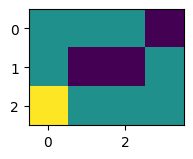

In [6]:
"""Custom node class for BFS search of problem space, allows for comparison of nodes by maze easily"""
class node:
  def __init__(self, maze, depth) -> None:
    self.up = None
    self.down = None
    self.left = None
    self.right = None
    self.maze = maze
    self.depth = depth
    self.sequence = []
    self.action = None

  def __eq__(self, other):
    if isinstance(other, node):
      val = np.isclose(self.maze, other.maze).all()
      return val
    else:
      return False

  def __ne__(self, other):
    return not self.__eq__(other)

  def __lt__(self, other):
    return self.__eq__(other)

  def __gt__(self, other):
    return self.__eq__(other)


#BFS style search of problem space
def s_bfs(maze, prob_maze):
  #Starting arrangement
  head = node(prob_maze, 0)
  min_node = node(None, np.Inf)
  fringe = []
  visited = []
  fringe.append(head)

  while fringe:
    cur_node = fringe.pop(0)
      
    #Check if node has been visited
    if any(x == cur_node for x in visited):
      continue
    visited.append(cur_node)
    #Check if action results in certainty
    cur_node.up = node(up(cur_node.maze.copy(), maze), cur_node.depth + 1)
    cur_node.up.sequence = cur_node.sequence[:]
    cur_node.up.sequence.append(0)
    if np.isclose(cur_node.up.maze.max(), 1):
      if cur_node.up.depth < min_node.depth:
        min_node = cur_node.up
        break
    cur_node.down = node(down(cur_node.maze.copy(), maze), cur_node.depth + 1)
    cur_node.down.sequence = cur_node.sequence[:]
    cur_node.down.sequence.append(0)
    if np.isclose(cur_node.down.maze.max(), 1):
      if cur_node.down.depth < min_node.depth:
        min_node = cur_node.down
        break
    cur_node.left = node(left(cur_node.maze.copy(), maze), cur_node.depth + 1)
    cur_node.left.sequence = cur_node.sequence[:]
    cur_node.left.sequence.append(0)
    if np.isclose(cur_node.left.maze.max(), 1):
      if cur_node.left.depth < min_node.depth:
        min_node = cur_node.left
        break
    cur_node.right = node(right(cur_node.maze.copy(), maze), cur_node.depth + 1)
    cur_node.right.sequence = cur_node.sequence[:]
    cur_node.right.sequence.append(0)
    if np.isclose(cur_node.right.maze.max(), 1):
      if cur_node.right.depth < min_node.depth:
        min_node = cur_node.right
        break
    #Add actions to fringe

    if cur_node != cur_node.up:
      fringe.append(cur_node.up)
    if cur_node != cur_node.down:
      fringe.append(cur_node.down)
    if cur_node != cur_node.left:
      fringe.append(cur_node.left)
    if cur_node != cur_node.right:
      fringe.append(cur_node.right)

  end_pos = np.where(min_node.maze == 1)
  end_pos = (end_pos[1], end_pos[0])
  if len(end_pos[0]) != 0:
    end_pos= end_pos[0][0]
  else:
    end_pos = (-1,-1)
  return min_node.depth, min_node.sequence, min_node.maze, end_pos

def main():
  maze_file_name = "very_tiny.txt"
  maze, prob_maze, free_cells = read_maze(maze_file_name)
  min_steps, min_sequence, min_maze, end_pos = s_bfs(maze, prob_maze)

  print("Sequence:", min_sequence)
  print("Steps:",min_steps)
  print("Expected Pos (y,x):", end_pos)
  print("Certainty Map: \nYellow is 100% certainty, zero certainties that are not walls are increased to show contrast")


  fig = plt.figure(figsize=(2,2))
  plt.imshow(np.where(maze != ['X'], np.where(min_maze == 0, (min_maze) + ((1/2)),min_maze) , 0))
  plt.show()
main()

# A* (Heuristic) Attempt:
In attempt to improve this algorithms speed in trade for accuracy, a heuristic based approach was attempted. The main difference over BFS is the use of a priority queue with the goal that some heuristics would provide a close enough result. 

Ultimately the heuristic I chose to use was the longest distance between any two nodes with non-zero probabilities, since the minimum distance is usually greater than or equal to that value, however this is not a perfect heuristic since in some cases this does not hold true. Even with this heuristic the execution on very large mazes like 19x19 is still not very fast and does not finish in a reasonable time. However if I take something like a 10x9 corner of the given schematic, it will execute very quickly and give an small approximate number of steps (it can do some larger mazes also, however it can not do significantly larger ones). This smaller version is saved in the tiny.txt file


Steps: 55 done
(array([0]), array([0]))
Sequence: [2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 3, 0, 3, 3, 1, 1, 1, 3, 3, 3, 3, 1, 3, 3, 1, 1, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2]
Steps: 55
Expected Pos (y,x): 0
Certainty Map: 
Yellow is 100% certainty, zero certainties that are not walls are increased to show contrast


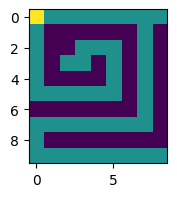

Testing with agents:
Agent 0 pos (y,x): 0 0
Agent 1 pos (y,x): 0 0
Agent 2 pos (y,x): 0 0
Agent 3 pos (y,x): 0 0
Agent 4 pos (y,x): 0 0


In [7]:

"""Heuristic assumes the two furthest appart non-zero prob cells is a good approximation for steps"""
def ld(maze, prob_maze, shortest_dists):
  dist = 0
  for i in range(len(prob_maze)):
    for j in range(len(prob_maze[i])):
      if prob_maze[i][j] > 0:
        for key, val in shortest_dists[i][j].items():
          if prob_maze[key] != 0 and val > dist:
            dist = val
            
  return dist

"""Heuristic search that uses priority queue instead of regular queue"""

def s_heur_search(maze, prob_maze):

  #Starting arrangement
  head = node(prob_maze, 0)
  min_node = node(None, np.Inf)
  min_sequence = []
  fringe = []
  visited = []
  shortest_dists = bfs_maze(maze, prob_maze)
  #Here comb_dist is an example heuristic tried
  heapq.heappush(fringe, (ld(maze, prob_maze, shortest_dists), head))
  while fringe:
    comb, cur_node = heapq.heappop(fringe)
    if any(x == cur_node for x in visited):
      continue
    visited.append(cur_node)
    #Checks if actions result in a certainty combination
    cur_node.up = node(up(cur_node.maze.copy(), maze), cur_node.depth + 1)
    
    cur_node.up.sequence = cur_node.sequence[:]
    cur_node.up.sequence.append(0)
    if np.isclose(cur_node.up.maze.max(), 1):
      if cur_node.up.depth < min_node.depth:
        min_node = cur_node.up
        break
    cur_node.down = node(down(cur_node.maze.copy(), maze), cur_node.depth + 1)
    
    cur_node.down.sequence = cur_node.sequence[:]
    cur_node.down.sequence.append(1)
    if np.isclose(cur_node.down.maze.max(), 1):
      if cur_node.down.depth < min_node.depth:
        min_node = cur_node.down
        break
    cur_node.left = node(left(cur_node.maze.copy(), maze), cur_node.depth + 1)

    cur_node.left.sequence = cur_node.sequence[:]
    cur_node.left.sequence.append(2)
    if np.isclose(cur_node.left.maze.max(), 1):
      if cur_node.left.depth < min_node.depth:
        min_node = cur_node.left
        break
    cur_node.right = node(right(cur_node.maze.copy(), maze), cur_node.depth + 1)

    cur_node.right.sequence = cur_node.sequence[:]
    cur_node.right.sequence.append(3)
    if np.isclose(cur_node.right.maze.max(), 1):
      if cur_node.right.depth < min_node.depth:
        min_node = cur_node.right
        break
    #Add new combination to heap with heuristic
    if cur_node != cur_node.up:
      heapq.heappush(fringe, (ld(maze, cur_node.up.maze, shortest_dists), cur_node.up))
    if cur_node != cur_node.down:
      heapq.heappush(fringe, (ld(maze, cur_node.down.maze, shortest_dists), cur_node.down))
    if cur_node != cur_node.left:
      heapq.heappush(fringe, (ld(maze, cur_node.left.maze, shortest_dists), cur_node.left))
    if cur_node != cur_node.right:
      heapq.heappush(fringe, (ld(maze, cur_node.right.maze, shortest_dists), cur_node.right))

  print("Steps:", min_node.depth, "done")
  end_pos = np.where(min_node.maze == 1)
  end_pos = (end_pos[1], end_pos[0]) 
  print(end_pos)
  if len(end_pos[0]) != 0:
    end_pos= end_pos[0][0]
  else:
    end_pos = (-1,-1)
  return min_node.depth, min_node.sequence, min_node.maze, end_pos
  

def main():
  
  maze_file_name = "tiny.txt"
  maze, prob_maze, free_cells = read_maze(maze_file_name)
  min_steps, min_sequence, min_maze, end_pos = s_heur_search(maze, prob_maze)

  print("Sequence:", min_sequence)
  print("Steps:",min_steps)
  print("Expected Pos (y,x):", end_pos)
  print("Certainty Map: \nYellow is 100% certainty, zero certainties that are not walls are increased to show contrast")


  fig = plt.figure(figsize=(2,2))
  plt.imshow(np.where(maze != ['X'], np.where(min_maze == 0, (min_maze) + ((1/2)),min_maze) , 0))
  plt.show()

  print("Testing with agents:")
  for itr in range(5):
    agent_obj = agent(maze)
    action = [agent_obj.up, agent_obj.down, agent_obj.left, agent_obj.right]
    for x in min_sequence:
      action[x]()
    print("Agent", itr, "pos (y,x):", agent_obj.y, agent_obj.x)

main()


Ultimately this solution gives reasonably short sequences (much better than random brute force) and is succesful on randomly spawned agents. This is because the heuristic results in minimize the distance between non-zero probability nodes and in doing so progresses towards the solution relatively quickly. 

In more complex problem spaces, the heuristic seems to be less succesful since there are many states in which the distance could be minimuzed.However it should still finish executing faster than BFS, with the consequence of a suboptimal solution.

# Chosen Alternate Solution:

Since these attempts both take too long to execution I considered ways to simplify the problem to get a fairly short path in a reasonable amount of time. Since all nodes move together, the minimum number of steps taken must be greater than or equal to the distance of some cell to the result cell (where certainty is reached). So if I know what cell is the result cell, I know the minimum steps is at a minimum the distance from that cell to the cell furthest away. 

Although I don't know what that cell is, I do know that it is most likely to be a corner cell since these cells allow for probability combinations from moves in two directions, versus cells next to walls which only allow for combinations from the direction perpendicular.

To simplify the problem, if I pick some corner, and find the furthest non-zero probability cell away and "walk" that cell to the corner, I will be certain that that cell and all cells it combined with on the way to the corner are at that corner. If I keep picking the furthest away non-zero cell from the corner and walking it to this corner, eventually the probability of that corner should be 1. This is because if a probability moves away from the corner, it will eventually be brought back. Choosing a path to walk can be done easily using the bfs shortest path look up I created previously.

This should result in a relatively low number of steps it attempts to minimize the furthest away non-zero probability by constantly hearding them to a single node. Since the furthest node is chosen at each iteration, that node should keep combining with other nodes as it attempts to progress to the chosen corner until it either arrives at that corner or manages to combine with all other non-zero probability cells so that certainty is reached.

While it would be difficult to find what corner is on average the best, finding corners in general is easy, and this hearding algorithm can be executed relatively fast meaning that it can be executed for each corner in the maze. The chosen corner which allows for certainty in the lowest number of steps is utimately the best on average. Although this is does not guarentee optimal results, it results in a fairly short number of steps for most mazes. Furthermore, in smaller or simpler mazes, the algorithm is usually able to find the shortest number of steps.

This relaxed version of the problem works fairly well, it is able to guess a shortest number of sequences in a very short period of time even for the full 19x19 given schematic. While it does not result in the shortest possible sequence of moves, it manages to find a sequence with fewer moves than the A* problem, taking only 46 versus A*'s 55. While I intitially thought this may also work to serve as a heurisitic, it would not be admissible since it over estmiates distances (consistent heurisitcs should underestimate or be equal), regardless it seems to give a relatively low step sequence for most mazes and in some mazes it gives a true minimum, however a shortest sequence is not guarenteed so this is a suboptimal solution.

Thor23-SA74-VERW-Schematic (Classified).txt
Sequence: [2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 3, 3, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0]
Steps: 162
Expected Pos (y,x): (0, 0)
Certainty Map: 
Yellow is 100% certainty, zero certainties that are not walls are increased to show contrast


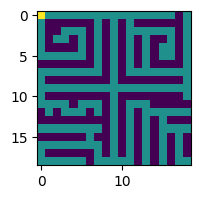

Testing with agents:
Agent 0 pos (y,x): 0 0
Agent 1 pos (y,x): 0 0
Agent 2 pos (y,x): 0 0
Agent 3 pos (y,x): 0 0
Agent 4 pos (y,x): 0 0
--------------------------------------------------------------------
Tiny.txt
Sequence: [2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 3, 3, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0]
Steps: 46
Expected Pos (y,x): (0, 0)
Certainty Map: 
Yellow is 100% certainty, zero certainties that are not walls are increased to show contrast


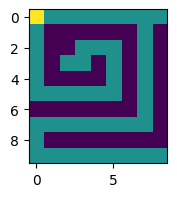

Testing with agents:
Agent 0 pos (y,x): 0 0
Agent 1 pos (y,x): 0 0
Agent 2 pos (y,x): 0 0
Agent 3 pos (y,x): 0 0
Agent 4 pos (y,x): 0 0


In [8]:
"""Function to return a list of every corner"""
def get_corners(maze, prob_maze):
  corners = set()
  for i in range(len(prob_maze)):
    for j in range(len(prob_maze[i])):
      if maze[i][j] != "X":
        #shapes of corners
        if (i - 1 < 0 or maze[i-1][j] == 'X') and (j - 1 < 0 or maze[i][j-1] == 'X') or (i - 1 < 0 or maze[i-1][j] == 'X') and (j + 1 >= len(maze[0]) or maze[i][j+1] == 'X') or (i + 1 >= len(maze) or maze[i+1][j] == 'X') and (j - 1 < 0 or maze[i][j-1] == 'X') or (i + 1 >= len(maze) or maze[i+1][j] == 'X') and (j + 1 >= len(maze[0]) or maze[i][j+1] == 'X'):
          corners.add((i,j))
  return list(corners)


"""Algorithm which attempts to find a cell of certainty in the fewest steps by picking a corner 
and continuously walking all far away non-zero probability cells to that corner until the maze is solves"""
def corners_algo(maze, prob_maze, free_cells):
  shortest_dists = bfs_maze(maze, prob_maze)

  min_steps = np.Inf
  min_sequence = []
  end_pos = np.Inf
  corners = get_corners(maze, prob_maze)
  min_maze = prob_maze

  #execute algo for each possible corner
  for goal_index in corners:
    steps = 0
    new_prob_maze = prob_maze.copy()
    sequence = []
    #while no certain
    while not np.isclose(new_prob_maze.max(), 1):
      #if too many steps are taken abandon corner
      if steps > min_steps or steps > 1000:
        break

      greatest_dist = 0
      g_pos = (0, 0)  #the furthest node
      #uses bfs shortest dist map to find furthest
      for key, item in shortest_dists[goal_index[0]][goal_index[1]].items():
        if item > greatest_dist and new_prob_maze[key] != 0:
          greatest_dist = item
          g_pos = key
    
      #while furthest distance node does not equal corner or result in certainty continue walking shortest path
      while g_pos != goal_index and not np.isclose(new_prob_maze.max(), 1):
        steps += 1
        shortest_path = shortest_dists[goal_index[0]][goal_index[1]].get((g_pos[0], g_pos[1]))
        action = down
        if not shortest_dists[goal_index[0]][goal_index[1]].get((g_pos[0] + 1, g_pos[1])) is None and shortest_dists[goal_index[0]][goal_index[1]].get((g_pos[0] + 1, g_pos[1])) < shortest_path:
          action = down
          shortest_path = shortest_dists[goal_index[0]][goal_index[1]].get((g_pos[0] + 1, g_pos[1]))

        if not shortest_dists[goal_index[0]][goal_index[1]].get((g_pos[0] - 1, g_pos[1])) is None and shortest_dists[goal_index[0]][goal_index[1]].get((g_pos[0] - 1, g_pos[1])) < shortest_path:
          action = up
          shortest_path = shortest_dists[goal_index[0]][goal_index[1]].get((g_pos[0] - 1, g_pos[1]))

        if not shortest_dists[goal_index[0]][goal_index[1]].get((g_pos[0], g_pos[1] + 1)) is None and shortest_dists[goal_index[0]][goal_index[1]].get((g_pos[0], g_pos[1] + 1)) < shortest_path:
          action = right
          shortest_path = shortest_dists[goal_index[0]][goal_index[1]].get((g_pos[0], g_pos[1] + 1))
        
        if not shortest_dists[goal_index[0]][goal_index[1]].get((g_pos[0], g_pos[1] - 1)) is None and shortest_dists[goal_index[0]][goal_index[1]].get((g_pos[0], g_pos[1] - 1)) < shortest_path:
          action = left
          shortest_path = shortest_dists[goal_index[0]][goal_index[1]].get((g_pos[0], g_pos[1] - 1)) 
          
        #add steps to sequence
        new_prob_maze = action(new_prob_maze, maze)
        if action == up:
          g_pos = (g_pos[0] - 1, g_pos[1])
          sequence.append(0)
        if action == down:
          g_pos = (g_pos[0] + 1, g_pos[1])
          sequence.append(1)
        if action == left:
          g_pos = (g_pos[0], g_pos[1] - 1)
          sequence.append(2)
        if action == right:
          g_pos = (g_pos[0], g_pos[1] + 1)
          sequence.append(3)

    #update minimums
    if steps < min_steps:
      min_steps = steps
      min_sequence = sequence
      end_pos = g_pos
      min_maze = new_prob_maze

  return min_sequence, min_maze, end_pos, min_sequence, min_steps
        

def main():
  
  maze_file_name = "Thor23-SA74-VERW-Schematic (Classified).txt"
  maze, prob_maze, free_cells = read_maze(maze_file_name)

  min_sequence, min_maze, end_pos, min_sequence, min_steps = corners_algo(maze,prob_maze,free_cells)
  print("Thor23-SA74-VERW-Schematic (Classified).txt")
  print("Sequence:", min_sequence)
  print("Steps:",min_steps)
  print("Expected Pos (y,x):", end_pos)
  print("Certainty Map: \nYellow is 100% certainty, zero certainties that are not walls are increased to show contrast")
  fig = plt.figure(figsize=(2, 2))
  plt.imshow(np.where(maze != ['X'], np.where(min_maze == 0, (min_maze) + ((1/2)),min_maze) , 0))
  plt.show()

  """Create 5 Agents Randomly in the Maze and force them to follow sequence"""
  print("Testing with agents:")
  #Prints the resulting position
  for itr in range(5):
    agent_obj = agent(maze)
    action = [agent_obj.up, agent_obj.down, agent_obj.left, agent_obj.right]
    for x in min_sequence:
      action[x]()
    print("Agent", itr, "pos (y,x):", agent_obj.y, agent_obj.x)

  """Testing with tiny.txt for comparison"""
  maze_file_name = "tiny.txt"
  maze, prob_maze, free_cells = read_maze(maze_file_name)

  min_sequence, min_maze, end_pos, min_sequence, min_steps = corners_algo(maze,prob_maze,free_cells)
  print("--------------------------------------------------------------------")
  print("Tiny.txt")
  print("Sequence:", min_sequence)
  print("Steps:",min_steps)
  print("Expected Pos (y,x):", end_pos)
  print("Certainty Map: \nYellow is 100% certainty, zero certainties that are not walls are increased to show contrast")
  fig = plt.figure(figsize=(2, 2))
  plt.imshow(np.where(maze != ['X'], np.where(min_maze == 0, (min_maze) + ((1/2)),min_maze) , 0))
  plt.show()

  """Create 5 Agents Randomly in the Maze and force them to follow sequence"""
  print("Testing with agents:")
  #Prints the resulting position
  for itr in range(5):
    agent_obj = agent(maze)
    action = [agent_obj.up, agent_obj.down, agent_obj.left, agent_obj.right]
    for x in min_sequence:
      action[x]()
    print("Agent", itr, "pos (y,x):", agent_obj.y, agent_obj.x)
  

main()


# Question 4

Proposed solution:

Due to the extremely high number of possible combinations of schematics for a 19x19 grid, brute force is not feasible. Additionally since my shortest possible path algorithm is not optimal, proving a maze requires a large number of steps is slightly more difficult. Howwever, to appraoch this problem I would use hill-climbing, where some initial schematic is created randomly with a lower number of walls and checked to be valid. If it is valid then the hill-climb would begin where the value of some schematic is the shortest possible sequence for that schematic, at each iteration, some combination of adding or removing walls is checked to see if it improves the value of the schematic until the schematic can not be improved. This algorithm could be made more robust using random restarts and simulated annealing (taking a worse descision with some probability), which should reduce the chance of finding a local minimum. Due to the very large state space, there is no guarentee that a most difficult schematic is found, however hill climbing should ensure that the schematics found are at least more difficult than the initial schematic or the intitial schematic can not easily be made to require more steps.

---

Using Smaller Mazes as Intuition:

Since my A* was not optimal, in order to implement some form of solution, I attempted to use knowledge I could gain from smaller mazes to build a larger one.

Although it not feasible to generate all 19x19 schematics and check to see which one is the longest, it is much more reasobale to do so using a much smaller schematic such as a 3x3. At this size, even the true BFS problem space algorithm can be used to guarentee an acurate shortest path length. 

The code below does this, generating all possible combinations for a 3x3 maze by using all length 9 binary strings reshapped to a 3x3 matrix such that 1 is a wall and 0 is a free space. A BFS for shortest path search is then run to eliminate mazes that are invalid (checks if free spaces are not connected). Once a valid set is established, the valid schematics are checked and the one requiring the most steps is returned.

The idea is that this most difficult schematic could provide insight for a potentially larger difficult one

In [9]:
def generate_three_by_three():

  """Create all possible combinations using reshapped binary strings where 0 is a free space and 1 is a wall"""
  """Eliminate all unsolvable mazes"""
  binary_strings = np.array([list(i) for i in itertools.product([0, 1], repeat=9)])
  string_mazes = []
  for x in binary_strings:
    m = np.reshape(x, (3,3))
    m = (np.where(m == 1, "X", "_"))
    free_spaces = np.count_nonzero(m == "_")
    #weeds out overly easy mazes
    if free_spaces < 3 or free_spaces == 9:
      continue
    combo = np.argwhere(m == "_")[0]
    y = combo[0]
    x = combo[1]
    _, dists = bfs(m, x, y)
    num_entries = len(dists)
    #if the number of connected cells is the same as total free spaces then valid
    if num_entries == free_spaces:
      string_mazes.append(m)
  
  """Check which of the valid mazes results in the most requred steps to solve"""
  longest_path = 0
  longest_maze = np.zeros((3,3))
  longest_sequence = 0
  print("Num Valid 3x3:", len(string_mazes))
  for i,x in enumerate(string_mazes):
    #runs problem space bfs
    prob_maze = np.where(x == "_", 1/np.count_nonzero(x == "_"), 0)
    free_cells = np.count_nonzero(x == "_")
    #path here just means min number of steps found
    path,_,_,_ = s_bfs(x, prob_maze)
    if path > longest_path:
      longest_path = path
      longest_maze = x
      #longest_sequence = sequence
      

  print("Min number of Steps Required: ", longest_path)
  print(longest_maze)

  return longest_maze

maze = generate_three_by_three()
  

Num Valid 3x3: 196
Min number of Steps Required:  6
[['_' '_' '_']
 ['_' 'X' '_']
 ['_' '_' '_']]


Using the knowledge that this is the most difficult 3x3 schematic I can use it as influence for a larger one, with the hope that the difficult scales. If the shape was not symetrical, I would have chosen to tile the pattern and rotate some of the tiles in order to create a potentially difficult pattern to solve, however since it is fully symetric square with a dot in the middle, it can be used to create larger concentric squares, where each inner square is like the dot in the middle, with the hope the difficulty will scale to when used in a larger scenario. The openings connecting the rings will be alternated in order to further increase the complexity by requiring more steps to combine the probability of an outer and inner ring.

Given a faster algorithm this could be potentially attempted with slighly bigger graphs, which may serve even better for finding patterns that are difficult when scaled up.

See code to create schematic and the resulting graph below:

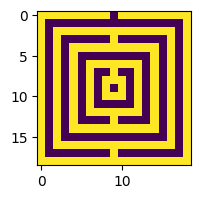

In [10]:
def generate_19x19():
    maze = np.where(np.zeros((19,19)) == 0, "X","_")

    """Build Concentric Square Pattern"""
    for x in range(0,10,2):
        for y in range(19-2*x):
            maze[x][x+y] = "_"
            maze[x+y][x] = "_"
            maze[19-1-x][x+y] = "_"
            maze[x+y][19-1-x] = "_"
        if x/2 % 2 == 0:
            maze[19-1-x-1][9] = "_"
        else:
            maze[x+1][9] = "_"
    maze[9][9] = "X"
    maze[0][9] = "X"

    return maze

maze = generate_19x19()
fig = plt.figure(figsize=(2,2))
plt.imshow(np.where(maze == "X",0,1))
plt.show()

Although my algorithm for solving for fewest number of steps is not perfect, it does allow for some testing to be done which will provide some insight to the difficulty of this maze:

Sequence: [3, 0, 0, 2, 0, 0, 3, 3, 3, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 2, 0, 0, 3, 3, 3, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Steps: 239
Expected Pos (y,x): (16, 16)
Certainty Map: 
Yellow is 100% certainty, zero certainties that are not walls are increased to show contrast


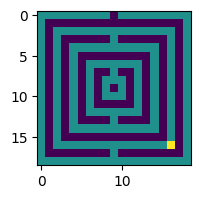

Testing with agents:
Agent 0 pos (y,x): 16 16
Agent 1 pos (y,x): 16 16
Agent 2 pos (y,x): 16 16
Agent 3 pos (y,x): 16 16
Agent 4 pos (y,x): 16 16


In [11]:
maze = generate_19x19()
np.savetxt("longmaze.txt",maze, delimiter="", fmt="%s") 
free_cells = np.count_nonzero(maze == "_")
prob_maze = np.where(maze == "_", 1/free_cells, 0)
min_sequence, min_maze, end_pos, min_sequence, min_steps = corners_algo(maze,prob_maze,free_cells)

print("Sequence:", min_sequence)
print("Steps:",min_steps)
print("Expected Pos (y,x):", end_pos)
print("Certainty Map: \nYellow is 100% certainty, zero certainties that are not walls are increased to show contrast")
fig = plt.figure(figsize=(2, 2))
plt.imshow(np.where(maze != ['X'], np.where(min_maze == 0, (min_maze) + ((1/2)),min_maze) , 0))
plt.show()

"""Create 5 Agents Randomly in the Maze and force them to follow sequence"""
print("Testing with agents:")
#Prints the resulting position
for itr in range(5):
  agent_obj = agent(maze)
  action = [agent_obj.up, agent_obj.down, agent_obj.left, agent_obj.right]
  for x in min_sequence:
    action[x]()
  print("Agent", itr, "pos (y,x):", agent_obj.y, agent_obj.x)

Based on the results, it appears that the concentric square schematic take significantly more steps than the initially provided one at 239 versus 162. Since each square layer is a different size and the layers are only connected by a single point, this means that a series of moves that provides a corner of high probability for a smaller layer will not be sufficient for a larger layer, meaning more steps will need to be taken. Additionally the inclusion of exits on opposing sides of consecutive squares means that more steps must be taken to combine probabilities between squares. Lastly the inclusion of the box at the top center is to reduce the connectedness of the outer layer, forcing more steps to be taken for combinations to occur.

When compared with other basic patterns that feature long halls with few connections such as spirals or zig zags, the concentric circle requires many more steps, suggesting it is a relatively difficult schematic. As can be seen below, these two other schematics take about 180 steps each. 

However, this is all based on my minimum sequence algorithm so it is possible that some solution exists in much fewer than 239 steps.


Spiral.txt
Sequence: [0, 0, 2, 2, 1, 1, 1, 1, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Steps: 180
Expected Pos (y,x): (0, 18)
Certainty Map: 
Yellow is 100% certainty, zero certainties that are not walls are increased to show contrast


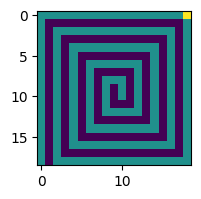

Zig Zags.txt
Sequence: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0]
Steps: 180
Expected Pos (y,x): (16, 0)
Certainty Map: 
Yellow is 100% certainty, zero certainties that are not walls are increased to show contrast


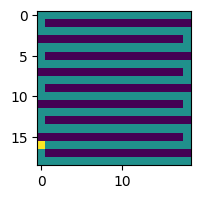

In [12]:
print("Spiral.txt")
maze_file_name = "spiral.txt"
maze, prob_maze, free_cells = read_maze(maze_file_name)

min_sequence, min_maze, end_pos, min_sequence, min_steps = corners_algo(maze,prob_maze,free_cells)

print("Sequence:", min_sequence)
print("Steps:",min_steps)
print("Expected Pos (y,x):", end_pos)
print("Certainty Map: \nYellow is 100% certainty, zero certainties that are not walls are increased to show contrast")
fig = plt.figure(figsize=(2, 2))
plt.imshow(np.where(maze != ['X'], np.where(min_maze == 0, (min_maze) + ((1/2)),min_maze) , 0))
plt.show()

print("Zig Zags.txt")
maze_file_name = "zigzags.txt"
maze, prob_maze, free_cells = read_maze(maze_file_name)

min_sequence, min_maze, end_pos, min_sequence, min_steps = corners_algo(maze,prob_maze,free_cells)

print("Sequence:", min_sequence)
print("Steps:",min_steps)
print("Expected Pos (y,x):", end_pos)
print("Certainty Map: \nYellow is 100% certainty, zero certainties that are not walls are increased to show contrast")
fig = plt.figure(figsize=(2, 2))
plt.imshow(np.where(maze != ['X'], np.where(min_maze == 0, (min_maze) + ((1/2)),min_maze) , 0))
plt.show()